In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import MobileNetV2, DenseNet201
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import shutil
import warnings
warnings.filterwarnings("ignore")

2025-06-30 20:16:43.427429: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751314603.608904      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751314603.660973      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Constants
RESIZE_DIM = (224, 224)
OUTPUT_DIR = '/kaggle/input/skin-cancer-disease-ham10000/Ham10000'
PROCESSED_DIR = '/kaggle/working/processed'

def has_black_borders(img, threshold=10):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = gray > threshold
    return not np.all(mask)

def zoom_until_no_borders(img, zoom_step=10, min_size=50):
    while has_black_borders(img):
        h, w, _ = img.shape
        if h <= min_size or w <= min_size:
            break
        img = img[zoom_step:h - zoom_step, zoom_step:w - zoom_step]
    return img

def apply_threshold(gray_image, lower_gray=20, upper_gray=100):
    return cv2.inRange(gray_image, lower_gray, upper_gray)

def find_and_draw_contours(image, mask, min_contour_area=500):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    image_with_contours = image.copy()
    for contour in contours:
        if cv2.contourArea(contour) >= min_contour_area:
            cv2.drawContours(image_with_contours, [contour], -1, (0, 255, 0), 2)
    return image_with_contours

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if has_black_borders(image):
        image = zoom_until_no_borders(image)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    equalized = cv2.equalizeHist(blurred)
    resized_color = cv2.resize(image, RESIZE_DIM)
    resized_gray = cv2.resize(equalized, RESIZE_DIM)
    
    mask = apply_threshold(resized_gray)
    gray_highlighted = cv2.bitwise_and(resized_gray, resized_gray, mask=mask)
    color_with_contours = find_and_draw_contours(resized_color, mask)
    gray_with_contours = find_and_draw_contours(resized_gray, mask)
    
    return {
        "original": resized_color,
        "gray": resized_gray,
        "highlighted": gray_highlighted,
        "color_contour": color_with_contours,
        "gray_contour": gray_with_contours
    }

def create_processed_dataset():
    for class_name in os.listdir(OUTPUT_DIR):
        class_path = os.path.join(OUTPUT_DIR, class_name)
        if not os.path.isdir(class_path):
            continue
        
        images = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
        
        for img_path in tqdm(images, desc=f"Processing {class_name}"):
            processed_images = preprocess_image(img_path)
            for key, img in processed_images.items():
                output_class_dir = os.path.join(PROCESSED_DIR, key, class_name)
                os.makedirs(output_class_dir, exist_ok=True)
                output_img_path = os.path.join(output_class_dir, os.path.basename(img_path))
                cv2.imwrite(output_img_path, img)
    print("Processed dataset created successfully!")

def count_images_in_classes(dataset_path):
    class_counts = {}
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            class_counts[class_name] = num_images
            print(f"Class '{class_name}': {num_images} images")
    return class_counts


In [8]:
create_processed_dataset()

count_images_in_classes(os.path.join(PROCESSED_DIR, "original"))
count_images_in_classes(os.path.join(PROCESSED_DIR, "gray"))
count_images_in_classes(os.path.join(PROCESSED_DIR, "highlighted"))
count_images_in_classes(os.path.join(PROCESSED_DIR, "color_contour"))
count_images_in_classes(os.path.join(PROCESSED_DIR, "gray_contour"))


Processing Dermatofibroma: 100%|██████████| 115/115 [00:01<00:00, 80.35it/s]


Processed dataset created successfully!
Class 'Melanocytic nevi': 6705 images
Class 'Vascular lesions': 142 images
Class 'Melanoma': 1113 images
Class 'Basal cell carcinoma': 514 images
Class 'Actinic keratoses': 327 images
Class 'Dermatofibroma': 115 images
Class 'Benign keratosis-like lesions': 1099 images
Class 'Melanocytic nevi': 6705 images
Class 'Vascular lesions': 142 images
Class 'Melanoma': 1113 images
Class 'Basal cell carcinoma': 514 images
Class 'Actinic keratoses': 327 images
Class 'Dermatofibroma': 115 images
Class 'Benign keratosis-like lesions': 1099 images
Class 'Melanocytic nevi': 6705 images
Class 'Vascular lesions': 142 images
Class 'Melanoma': 1113 images
Class 'Basal cell carcinoma': 514 images
Class 'Actinic keratoses': 327 images
Class 'Dermatofibroma': 115 images
Class 'Benign keratosis-like lesions': 1099 images
Class 'Melanocytic nevi': 6705 images
Class 'Vascular lesions': 142 images
Class 'Melanoma': 1113 images
Class 'Basal cell carcinoma': 514 images
Clas

{'Melanocytic nevi': 6705,
 'Vascular lesions': 142,
 'Melanoma': 1113,
 'Basal cell carcinoma': 514,
 'Actinic keratoses': 327,
 'Dermatofibroma': 115,
 'Benign keratosis-like lesions': 1099}

# Color Contour

In [16]:
original_dir_color_contour = '/kaggle/working/processed/color_contour'
output_dir_color_contour = '/kaggle/working/color_contour_split'

for split_color_contour in ['train_color_contour', 'val_color_contour', 'test_color_contour']:
    os.makedirs(f"{output_dir_color_contour}/{split_color_contour}", exist_ok=True)

print("✅ Started splitting...\n")

for class_name_color_contour in os.listdir(original_dir_color_contour):
    class_path_color_contour = os.path.join(original_dir_color_contour, class_name_color_contour)
    if os.path.isdir(class_path_color_contour):
        images_color_contour = os.listdir(class_path_color_contour)
        random.shuffle(images_color_contour)
        n_color_contour = len(images_color_contour)
        train_n_color_contour = int(0.7 * n_color_contour)
        val_n_color_contour = int(0.15 * n_color_contour)

        train_files_color_contour = images_color_contour[:train_n_color_contour]
        val_files_color_contour = images_color_contour[train_n_color_contour:train_n_color_contour + val_n_color_contour]
        test_files_color_contour = images_color_contour[train_n_color_contour + val_n_color_contour:]

        for split_name_color_contour, split_files_color_contour in zip(['train_color_contour', 'val_color_contour', 'test_color_contour'], [train_files_color_contour, val_files_color_contour, test_files_color_contour]):
            split_class_dir_color_contour = os.path.join(output_dir_color_contour, split_name_color_contour, class_name_color_contour)
            os.makedirs(split_class_dir_color_contour, exist_ok=True)
            for file_color_contour in split_files_color_contour:
                shutil.copy(os.path.join(class_path_color_contour, file_color_contour), os.path.join(split_class_dir_color_contour, file_color_contour))
        
        print(f"✅ Class: {class_name_color_contour}")
        print(f"   Train: {len(train_files_color_contour)}")
        print(f"   Val:   {len(val_files_color_contour)}")
        print(f"   Test:  {len(test_files_color_contour)}")
        print("-" * 40)

print("\n✅✅ Splitting complete ✔️")


✅ Started splitting...

✅ Class: Melanocytic nevi
   Train: 4693
   Val:   1005
   Test:  1007
----------------------------------------
✅ Class: Vascular lesions
   Train: 99
   Val:   21
   Test:  22
----------------------------------------
✅ Class: Melanoma
   Train: 779
   Val:   166
   Test:  168
----------------------------------------
✅ Class: Basal cell carcinoma
   Train: 359
   Val:   77
   Test:  78
----------------------------------------
✅ Class: Actinic keratoses
   Train: 228
   Val:   49
   Test:  50
----------------------------------------
✅ Class: Dermatofibroma
   Train: 80
   Val:   17
   Test:  18
----------------------------------------
✅ Class: Benign keratosis-like lesions
   Train: 769
   Val:   164
   Test:  166
----------------------------------------

✅✅ Splitting complete ✔️


In [17]:
img_height_color_contour, img_width_color_contour = 224, 224
batch_size_color_contour = 32

train_datagen_color_contour = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen_color_contour = ImageDataGenerator(rescale=1./255)

train_data_color_contour = train_datagen_color_contour.flow_from_directory(
    f"{output_dir_color_contour}/train_color_contour",
    target_size=(img_height_color_contour, img_width_color_contour),
    batch_size=batch_size_color_contour,
    class_mode='categorical',
    shuffle=True
)

val_data_color_contour = val_test_datagen_color_contour.flow_from_directory(
    f"{output_dir_color_contour}/val_color_contour",
    target_size=(img_height_color_contour, img_width_color_contour),
    batch_size=batch_size_color_contour,
    class_mode='categorical',
    shuffle=False
)

test_data_color_contour = val_test_datagen_color_contour.flow_from_directory(
    f"{output_dir_color_contour}/test_color_contour",
    target_size=(img_height_color_contour, img_width_color_contour),
    batch_size=batch_size_color_contour,
    class_mode='categorical',
    shuffle=False
)

num_classes_color_contour = train_data_color_contour.num_classes


Found 9092 images belonging to 7 classes.
Found 2772 images belonging to 7 classes.
Found 2776 images belonging to 7 classes.


In [18]:
def build_model(base_model_class, input_shape=(224, 224, 3), num_classes=7):
    base_model = base_model_class(include_top=False, weights='imagenet', input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [19]:
model_color_contour = build_model(DenseNet201, input_shape=(224, 224, 3), num_classes=num_classes_color_contour)
model_color_contour.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_color_contour = ModelCheckpoint('best_densenet201_color_contour.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

model_color_contour.fit(
    train_data_color_contour,
    validation_data=val_data_color_contour,
    epochs=50,
    callbacks=[checkpoint_color_contour]
)


Epoch 1/50
166/285 ━━━━━━━━━━━━━━━━━━━━ 46s 392ms/step - accuracy: 0.3808 - loss: 1.7846

2025-06-30 15:32:50.440663: E external/local_xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module a_inference_one_step_on_data_770130__.89618] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-06-30 15:36:23.276997: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 5m32.836468365s

********************************
[Compiling module a_inference_one_step_on_data_770130__.89618] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4633 - loss: 1.5642
Epoch 1: val_accuracy improved from -inf to 0.68975, saving model to best_densenet201_color_contour.h5
285/285 ━━━━━━━━━━━━━━━━━━━━ 988s 2s/step - accuracy: 0.4638 - loss: 1.5628 - val_accuracy: 0.6898 - val_loss: 0.8630
Epoch 2/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.6978 - loss: 0.8907
Epoch 2: val_accuracy improved from 0.68975 to 0.73701, saving model to best_densenet201_color_contour.h5
285/285 ━━━━━━━━━━━━━━━━━━━━ 120s 421ms/step - accuracy: 0.6978 - loss: 0.8906 - val_accuracy: 0.7370 - val_loss: 0.7239
Epoch 3/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.7239 - loss: 0.7698
Epoch 3: val_accuracy improved from 0.73701 to 0.76263, saving model to best_densenet201_color_contour.h5
285/285 ━━━━━━━━━━━━━━━━━━━━ 120s 422ms/step - accuracy: 0.7239 - loss: 0.7697 - val_accuracy: 0.7626 - val_loss: 0.6533
Epoch 4/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.7505 - 

87/87 ━━━━━━━━━━━━━━━━━━━━ 51s 373ms/step
✅ Test Accuracy (Color Contour): 0.9456

✅ Classification Report (Color Contour):
                               precision    recall  f1-score   support

            Actinic keratoses       0.95      0.86      0.90        93
         Basal cell carcinoma       0.90      0.91      0.90       141
Benign keratosis-like lesions       0.85      0.94      0.89       307
               Dermatofibroma       1.00      0.91      0.95        32
             Melanocytic nevi       0.98      0.96      0.97      1858
                     Melanoma       0.84      0.91      0.88       305
             Vascular lesions       1.00      0.93      0.96        40

                     accuracy                           0.95      2776
                    macro avg       0.93      0.92      0.92      2776
                 weighted avg       0.95      0.95      0.95      2776



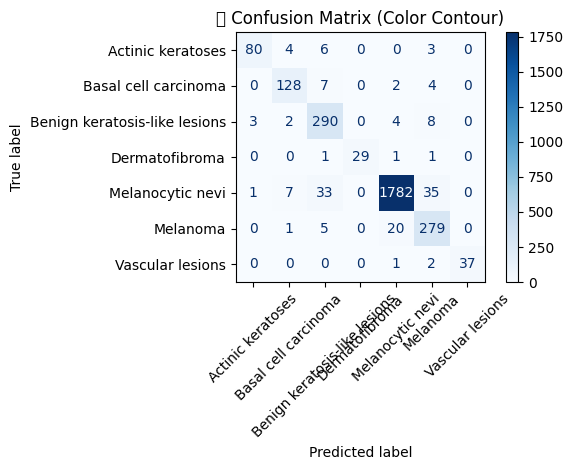

In [20]:
# Step 1: Predict class probabilities
y_pred_probs_color_contour = model_color_contour.predict(test_data_color_contour, verbose=1)

# Step 2: Convert probabilities to class indices
y_pred_color_contour = np.argmax(y_pred_probs_color_contour, axis=1)

# Step 3: Get true class indices
y_true_color_contour = test_data_color_contour.classes

# Step 4: Calculate test accuracy
test_accuracy_color_contour = accuracy_score(y_true_color_contour, y_pred_color_contour)
print(f"✅ Test Accuracy (Color Contour): {test_accuracy_color_contour:.4f}")

# Step 5: Print classification report
class_labels_color_contour = list(test_data_color_contour.class_indices.keys())
print("\n✅ Classification Report (Color Contour):")
print(classification_report(y_true_color_contour, y_pred_color_contour, target_names=class_labels_color_contour))

# Step 6: Confusion Matrix
cm_color_contour = confusion_matrix(y_true_color_contour, y_pred_color_contour)
disp_color_contour = ConfusionMatrixDisplay(confusion_matrix=cm_color_contour, display_labels=class_labels_color_contour)
disp_color_contour.plot(cmap='Blues', xticks_rotation=45)
plt.title("✅ Confusion Matrix (Color Contour)")
plt.tight_layout()
plt.show()
